In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb

In [2]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [4]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [5]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2000 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "KRICHA2"

# TABLEAU DE BORD DES JO

## Partie consultation des données

In [6]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  KLENTZ
Mot de passe :  ········


In [7]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 25


### Statistiques de base : participation

#### Nombre de nations participant à ces JO

In [8]:
# Calculer avec une requête et afficher le nombre de nations participant à cette édition
nationJO = requete_vers_dataframe(conn, f"""SELECT COUNT(DISTINCT NOC) AS "nbNationJO" FROM (
SELECT NOC FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
UNION ALL
SELECT NOC FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE E ON E.idEquipe = PE.idEquipe
WHERE IDHOTE = '{id_hote}')""")

# afficher la carte des épreuves 
display(HTML(f"<b><font size='+2'>Nombre de nation participant au {EDITION_JO}</font></b>"))
display(nationJO)

,nbNationJO
0,200


#### Nombre d'athlètes participant à ces JO, répartition par genre et /ou par pays

In [9]:
# Calculer avec une requête et afficher le nombre d’athlètes participant et la répartition par genre et/ou par pays

athleteJO = requete_vers_dataframe(conn, f"""SELECT idAthlete, Genre, NOC FROM(
SELECT A.idAthlete, A.Genre, PI.NOC  FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = PI.idAthlete
WHERE IDHOTE = '{id_hote}'
UNION ALL
SELECT A.idAthlete, A.Genre, E.NOC  FROM EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE E ON E.idEquipe = PE.idEquipe
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idEquipe = E.idEquipe
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = CE.idAthlete
WHERE IDHOTE = '{id_hote}')""")

# nombre total d'athlete
nombre_athletes = athleteJO[['IDATHLETE']].nunique()
display(HTML(f"<b>Nombre d'athlete participant au {EDITION_JO}</b>"))
print(nombre_athletes.values)
# nombre d'athlete par genre
repartition_genre = athleteJO['GENRE'].value_counts()
display(HTML(f"<b>Tableau répartition par genre :</b>"))
display(pd.DataFrame(repartition_genre).reset_index().rename(columns = {'count': 'Nombre'}))
# nombre d'athlete par pays
repartition_pays = athleteJO['NOC'].value_counts()
display(HTML(f"<b>Tableau répartition par pays :</b>"))
display(pd.DataFrame(repartition_pays).reset_index().rename(columns = {'count': 'Nombre'}).head())

[10832]


,GENRE,Nombre
0,Male,8516
1,Female,5525


,NOC,Nombre
0,AUS,803
1,USA,781
2,RUS,606
3,GER,578
4,FRA,473


### Les médailles décernées lors de ces JO

#### Médailles individuelles (épreuves individuelles)

##### Tableau du TOP 10 individuel

,IDATHLETE,PRENOMATHLETE,NOMATHLETE,GOLD,SILVER,BRONZE,TOTAL
0,30978,Aleksey,Nemov,2,1,2,5
1,13253,Leontien,Zijlaard-van Moorsel,3,1,0,4
2,49315,Inge,de Bruijn,3,0,0,3
3,93833,Yana,Klochkova,2,1,0,3
4,49500,Pieter,van den Hoogenband,2,0,1,3
5,48575,Massi,Rosolino,1,1,1,3
6,51218,Dara,Torres,0,0,3,3
7,13061,Félicia,Ballanger,2,0,0,2
8,50965,Brooke,Bennett,2,0,0,2
9,93557,Domenico,Fioravanti,2,0,0,2


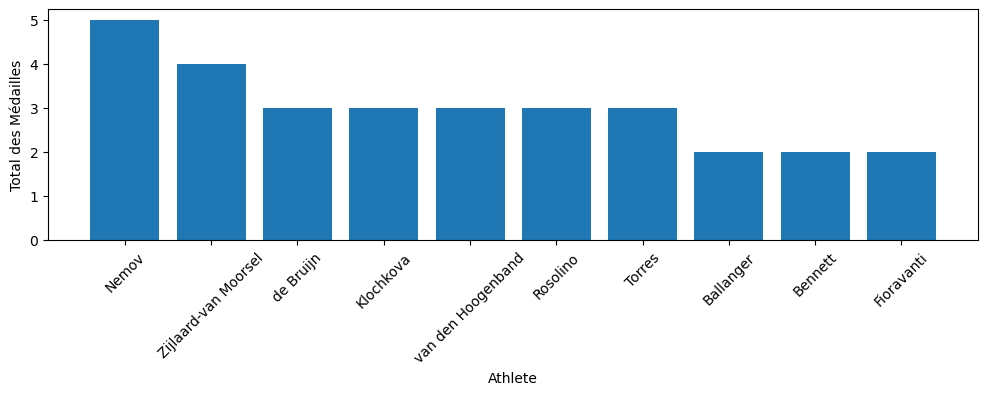

In [10]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
classementAthletesIndividuel = requete_vers_dataframe(conn,f""" SELECT  A.idAthlete, A.prenomAthlete, A.nomAthlete,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = PI.idAthlete
WHERE IDHOTE = '{id_hote}'
GROUP BY A.idAthlete, A.prenomAthlete, A.nomAthlete
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, nomathlete, 
prenomathlete, idathlete""")
# recuperer les 10 premieres lignes de la dataframe
athleteTop10Individuel = classementAthletesIndividuel.iloc[0:10]
display(HTML(f"<b><font size='+2'>Tableau du top 10 athlete individuel :</font></b>"))
display(athleteTop10Individuel)

# taille de la figure
plt.figure(figsize=(12, 3))
# affichage des bars
plt.bar(athleteTop10Individuel['NOMATHLETE'], athleteTop10Individuel['TOTAL'])
plt.xlabel('Athlete')
plt.ylabel('Total des Médailles')
display(HTML(f"<b><font size='+2'>Graphique du top 10 athlete individuel :</font></b>"))
# orientation du texte "Athlete"
plt.xticks(rotation=45)
plt.show()

##### Répartition par NOC

,NOC,GOLD,SILVER,BRONZE,TOTAL
0,RUS,24,23,25,72
1,USA,24,17,24,65
2,CHN,21,10,12,43
3,GER,6,14,14,34
4,AUS,7,15,10,32
5,FRA,9,11,8,28
6,CUB,10,9,5,24
7,ITA,9,5,9,23
8,KOR,6,8,7,21
9,GBR,9,5,5,19


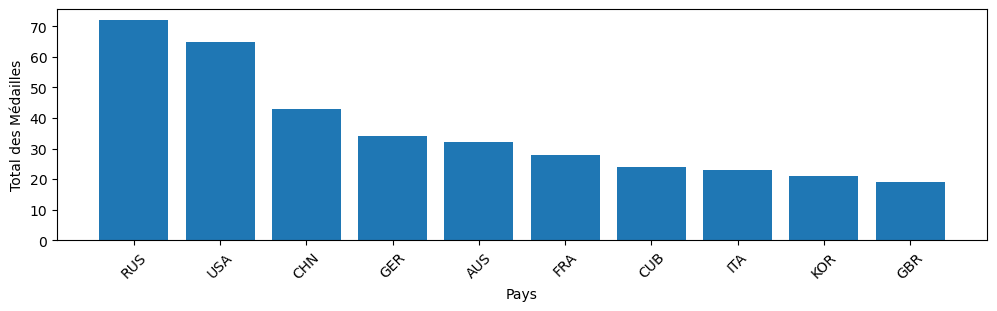

In [11]:
## Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
classementNocIndividuel = requete_vers_dataframe(conn,f"""SELECT PI.NOC,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
GROUP BY PI.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, noc""")
# récuperer les 10 premiers ligne de la dataframe
NOCTop10Individuel = classementNocIndividuel.iloc[0:10]
display(HTML(f"<b><font size='+2'>Tableau du top 10 NOC en individuel :</font></b>"))
display(NOCTop10Individuel)

plt.figure(figsize=(12, 3))
plt.bar(NOCTop10Individuel['NOC'], NOCTop10Individuel['TOTAL'])
plt.xlabel('Pays')
plt.ylabel('Total des Médailles')
display(HTML(f"<b><font size='+2'>Graphique du top 10 NOC en individuel :</font></b>"))
# orientation du texte "Pays"
plt.xticks(rotation=45)
plt.show()

#### Médailles par équipes (épreuves par équipe)

##### Tableau du TOP 10 par équipe

,IDATHLETE,PRENOMATHLETE,NOMATHLETE,GOLD,SILVER,BRONZE,TOTAL
0,51217,Jenny,Thompson,3,0,0,3
1,45230,Michael,Klim,2,1,0,3
2,93280,Ian,Thorpe,2,1,0,3
3,50021,Olga,Brusnikina,2,0,0,2
4,92674,Georgeta,Damian-Andrunache,2,0,0,2
5,9879,Birgit,Fischer-Schmidt,2,0,0,2
6,39501,Doina,Ignat,2,0,0,2
7,10072,Zoltán,Kammerer,2,0,0,2
8,50025,Mariya,Kiselyova,2,0,0,2
9,93273,Todd,Pearson,2,0,0,2


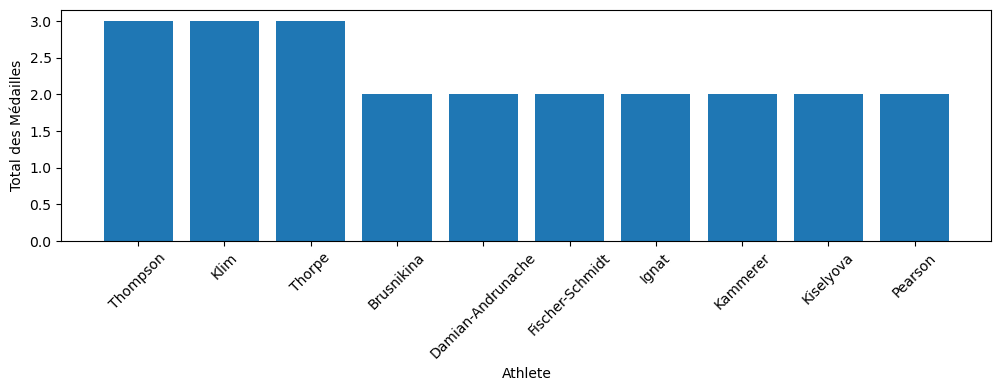

In [12]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique

classementAthletesEquipe = requete_vers_dataframe(conn,f""" SELECT  A.idAthlete, A.prenomAthlete, A.nomAthlete,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idEquipe = PE.idEquipe
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = CE.idAthlete
WHERE IDHOTE = '{id_hote}'
GROUP BY A.idAthlete, A.prenomAthlete, A.nomAthlete
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, nomathlete, 
prenomathlete, idathlete""")
# recupérer les 10 premieres lignes de la dataframe
athleteTop10Equipe = classementAthletesEquipe.iloc[0:10]
display(HTML(f"<b><font size='+2'>Tableau du top 10 athlete en équipe :</font></b>"))
display(athleteTop10Equipe)     
# taille de la figure
plt.figure(figsize=(12, 3))
# affichage des bars
plt.bar(athleteTop10Equipe['NOMATHLETE'], athleteTop10Equipe['TOTAL'])
plt.xlabel('Athlete')
plt.ylabel('Total des Médailles')
display(HTML(f"<b><font size='+2'>Graphique du top 10 athlete en équipe :</font></b>"))
# orientation des titres 'ATHLETE'
plt.xticks(rotation=45)
plt.show()

##### Répartition par NOC

   NOC  GOLD  SILVER  BRONZE  TOTAL
0  USA    13       7       8     28
1  AUS     9      10       7     26
2  GER     7       3      12     22
3  RUS     8       5       4     17
4  CHN     7       6       2     15
5  ITA     4       3       4     11
6  FRA     4       3       3     10
7  GBR     2       5       2      9
8  NED     1       6       2      9
9  BRA     0       3       6      9


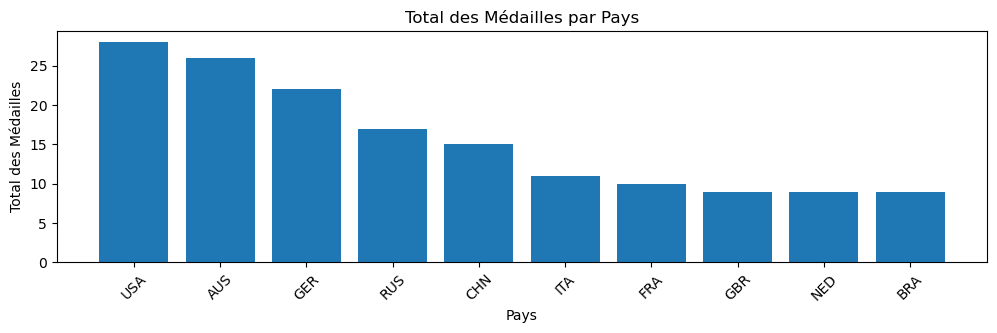

In [13]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique

classementNocEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
WHERE IDHOTE = '{id_hote}'
GROUP BY EQ.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, eq.noc""")
# recupérer les 10 premieres 10 lignes de la dataframe
NOCTop10Equipe = classementNocEquipe.iloc[0:10]
display(HTML(f"<b><font size='+2'>Graphique du top 10 NOC en équipe :</font></b>"))
print(NOCTop10Equipe)   

plt.figure(figsize=(12, 3))
plt.bar(NOCTop10Equipe['NOC'], NOCTop10Equipe['TOTAL'])
plt.xlabel('Pays')
plt.ylabel('Total des Médailles')
plt.title('Total des Médailles par Pays')
display(HTML(f"<b><font size='+2'>Graphique du top 10 NOC en équipe :</font></b>"))
# orientation des titres 'PAYS'
plt.xticks(rotation=45)
plt.show()

## Partie modification des données

On décide d'ajouter à l'édition des JO étudiée une nouvelle épreuve : le tir à l'arc à poulies. C'est une épreuve de tir à l'arc (*archery*, code `ARC`), qui se fait soit en arc à poulies homme (individuel ou équipe, mais on ne traitera que le cas individuel), soit arc à poulies femmes (individuel ou équipe). Les noms à utiliser pour les événements seront :

- *Compound individual, Men*
- *Compound individual, Women*

Pour simuler les résultats, vous utiliserez les résultats de l'épreuve de [tir à l'arc classique des JO de 2020 en individuel homme](https://www.olympedia.org/results/18000492) en faisant comme s'il s'agissait d'arc à poulies : les athlètes existent déjà dans la base, vous devez maintenant faire en sorte d'ajouter à la base les différents résultats.

Avant de réaliser les modifications, affichez le tableau des médailles individuelles pour l'Italie

In [14]:
# On donne ici l'exemple de comment ajouter un événement. On a stocké dans id_hote l'identifiant des JO sur lesquels on travaille
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
    # On démarre une nouvelle transaction
    connexion.begin()
    # On ouvre un curseur, qui est une sorte de pointeur vers une table de résultats
    curseur = connexion.cursor()
    # On passe la requête paramétrée et les paramètres (s'il y en a) au curseur
    curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
    # S'il n'y a pas d'erreur, on peut demander à récupérer les résultats : 
    # - curseur.fetchone() récupère la ligne sur laquelle pointe le curseur, renvoie le résultat sous forme de tuple, et avance à la ligne suivante (si elle existe)
    # - curseur.fetchall() boucle sur toutes les lignes restantes et renvoie une liste de tuples, ou une liste vide s'il n'y a plus de résultats
    # - curseur.fetchmany(nb) renvoie les résultats des nb lignes suivantes sous forme de liste de tuples
    idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
    idev += 1
    print(id_hote)
    print(idev)
    curseur.execute(f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)", {'idev': idev, 'nomev': 'Compound Individual, Men', 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote})
    curseur.execute(f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)", {'idev': idev+1, 'nomev': 'Compound Individual, Women', 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote})
    connexion.commit()  #On commit (# On annule, ce qui est au dessus est pour l'exemple, vous devrez utiliser commit() pour valider la transaction.)

25
90016771


In [15]:
# Afficher le tableau des médailles individuelles de l'Italie
display(HTML(f"<b><font size='+2'>Tableau des médailles individuelles de l'Italie:</font></b>"))
display(classementNocIndividuel[classementNocIndividuel['NOC'] == 'ITA'])

,NOC,GOLD,SILVER,BRONZE,TOTAL
7,ITA,9,5,9,23


### Qualifications [Bonus]

Le round de qualifications en tir à l'arc à poulie est assez similaire au tir à l'arc classique, avec comme différence qu'il n'y a pas de "X", ils comptent comme des 10 pour départager. En utilisant le tableau des résultats de qualifications, faites en sorte que votre tableau de bord insère les données dans la base puis les affiche.

In [16]:
# Faire ici l'insertion des données
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    id_manche = 1
    manche_resultat = id_manche
    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche} , 'Ranking Round' )")
    # Ajout des libelle correspondants aux résultats 
    curseur.execute(f"INSERT INTO {SCHEMA}.resultat_libelle(idevenement, idmanche, libelle1, libelle2, libelle3, libelle4, libelle5) VALUES ({idev}, {id_manche} , 'Points', '10s', 'Xs', 'Part #1', 'Part #2')")

    #Ajout des résultats
    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '688', '43', '15', '345 (1)', '343 (4)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 144969, '688', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '682', '41', '14', '337 (7)', '345 (1)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 111530, '682', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '681', '39', '18', '337 (9)', '344 (3)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 124388, '681', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '680', '37', '23', '340 (2)', '340 (5)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 134919, '680', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '678', '37', '12', '333 (18)', '345 (2)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 2103727, '678', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '675', '37', '9', '338 (4)', '337 (7)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 145535, '675', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '674', '35', '6', '338 (5)', '336 (10)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 141803, '674', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '670', '30', '15', '334 (16)', '336 (11)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 135226, '670', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '669', '34', '10', '338 (3)', '331 (17)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 126848, '669', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '669', '32', '9', '337 (6)', '332 (16)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 136120, '669', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '669', '31', '9', '332 (21)', '337 (6)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 141802, '669', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '668', '31', '8', '336 (11)', '332 (14)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 2504096, '668', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '668', '28', '10', '332 (22)', '336 (9)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 133130, '668', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '667', '29', '11', '334 (15)', '333 (13)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 145534, '667', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '666', '29', '8', '337 (10)', '329 (25)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 134406, '666', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '665', '27', '7', '328 (35)', '337 (8)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 111544, '665', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '662', '28', '10', '337 (8)', '325 (44)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 140936, '662', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '662', '27', '12', '331 (24)', '331 (20)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 141609, '662', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '662', '25', '13', '334 (17)', '328 (33)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 122283, '662', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '661', '28', '12', '335 (12)', '326 (40)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 126326, '661', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '661', '26', '8', '329 (28)', '332 (15)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 136070, '661', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '661', '26', '6', '332 (20)', '329 (26)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 144501, '661', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '660', '30', '12', '334 (14)', '326 (39)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 144000, '660', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '658', '28', '10', '328 (34)', '330 (22)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 111536, '658', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '658', '28', '9', '335 (13)', '323 (51)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 133959, '658', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '658', '26', '9', '331 (25)', '327 (34)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143709, '658', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '657', '27', '9', '329 (29)', '328 (28)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 144763, '657', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '656', '27', '8', '332 (19)', '324 (=49)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 147048, '656', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '656', '26', '10', '325 (38)', '331 (19)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 147311, '656', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '656', '26', '9', '328 (36)', '328 (27)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 146850, '656', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '656', '22', '5', '329 (30)', '327 (38)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143748, '656', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '655', '26', '10', '330 (26)', '325 (43)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143710, '655', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '654', '23', '6', '330 (27)', '324 (=49)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143339, '654', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '653', '24', '8', '322 (=49)', '331 (18)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 146210, '653', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '653', '24', '7', '329 (31)', '324 (48)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 134416, '653', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '653', '23', '7', '326 (37)', '327 (=35)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 133798, '653', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '652', '26', '6', '323 (45)', '329 (24)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 102875, '652', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '652', '21', '11', '329 (33)', '323 (52)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143091, '652', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '651', '23', '8', '324 (43)', '327 (37)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 121560, '651', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '651', '21', '9', '325 (=39)', '326 (41)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 132752, '651', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '651', '21', '8', '321 (52)', '330 (23)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 146550, '651', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '650', '25', '8', '331 (23)', '319 (61)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 132453, '650', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '650', '23', '7', '322 (=49)', '328 (=31)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 140989, '650', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '650', '21', '6', '329 (32)', '321 (59)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 142460, '650', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '649', '26', '6', '316 (57)', '333 (12)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 142674, '649', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '649', '23', '5', '322 (48)', '327 (=35)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 102879, '649', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '649', '22', '5', '321 (51)', '328 (=31)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 126572, '649', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '649', '18', '7', '321 (53)', '328 (30)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143092, '649', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '648', '25', '6', '323 (46)', '325 (42)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 124865, '648', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '648', '21', '11', '325 (41)', '323 (55)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 102853, '648', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '648', '21', '7', '325 (=39)', '323 (56)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 142799, '648', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '647', '22', '12', '319 (54)', '328 (29)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 144764, '647', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '647', '20', '5', '322 (47)', '325 (47)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 147597, '647', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '646', '22', '6', '325 (42)', '321 (58)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 145357, '646', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '646', '21', '7', '324 (44)', '322 (57)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 102885, '646', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '645', '28', '9', '315 (59)', '330 (21)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 2502893, '645', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '640', '21', '8', '315 (58)', '325 (46)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 111548, '640', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '639', '22', '7', '314 (60)', '325 (45)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 123462, '639', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '637', '19', '6', '317 (56)', '320 (60)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 2069, '637', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '635', '19', '8', '312 (61)', '323 (53)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143957, '635', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '632', '15', '5', '319 (55)', '313 (63)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 143664, '632', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '631', '16', '4', '308 (63)', '323 (54)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 146900, '631', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '629', '18', '4', '312 (62)', '317 (62)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 127171, '629', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    curseur.execute(f"INSERT INTO {SCHEMA}.resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4, resultat5) VALUES ((SELECT COUNT(*)+1 FROM {SCHEMA}.resultat),{idev}, {id_manche}, '582', '13', '2', '282 (64)', '300 (64)')")
    curseur.execute(f"INSERT INTO {SCHEMA}.performance_individuelle VALUES ({idev}, {id_manche}, 135095, '582', 'Points', null, (SELECT COUNT(*) FROM {SCHEMA}.resultat))")

    connexion.commit()

In [17]:
# Faire ici l'affichage du tableau de résultat des qualifications
libelle = requete_vers_dataframe(conn, f"""SELECT libelle1, libelle2, libelle3, libelle4, libelle5 FROM {SCHEMA}.resultat_libelle
                        WHERE idevenement = {idev} AND idmanche = {id_manche}""")

ranking = requete_vers_dataframe(conn, f"""
SELECT DISTINCT nomathlete, prenomathlete, noc, resultat1, resultat2, resultat3, resultat4, resultat5 
FROM {SCHEMA}.performance_individuelle pi
INNER JOIN {SCHEMA}.resultat r ON r.idresultat = pi.resultat_detaille
INNER JOIN {SCHEMA}.athlete a ON a.idathlete = pi.idathlete
INNER JOIN {SCHEMA}.participation_individuelle ppi ON ppi.idathlete = a.idathlete
INNER JOIN {SCHEMA}.evenement e ON e.idevenement = ppi.idevent
INNER JOIN {SCHEMA}.hote h ON h.idhote = e.idhote
WHERE pi.idevenement = 90016771 AND pi.idmanche = 1 AND h.anneehote = 2020
ORDER BY TO_NUMBER(resultat1) DESC, TO_NUMBER(resultat2) DESC, TO_NUMBER(resultat3) DESC, 
nomathlete, prenomathlete, noc
""")

#On ajuste le nombre de colonne en fonction nu nombre de libelle (on part du principe qu'il y a autant d'infos que de libelle)
colonnes = libelle.iloc[0].tolist()
for i in reversed(range(len(colonnes))):
    if colonnes[i] is None:
        colonnes.pop(i)
        ranking.drop(columns=[ranking.columns[i + 3]], inplace=True)

#On renommes les colonnes du dataframe en fonction des libelles
ranking.columns = ['NOMATHLETE', 'PRENOMATHLETE', 'NOC'] + colonnes
display(HTML(f"<b><font size='+2'>Résultat des qualifications :</font></b>"))
display(ranking)

,NOMATHLETE,PRENOMATHLETE,NOC,Points,10s,Xs,Part #1,Part #2
0,Je-Deok,Kim,KOR,688,43,15,345 (1),343 (4)
1,Ellison,Brady,USA,682,41,14,337 (7),345 (1)
2,Jin-Hyeok,Oh,KOR,681,39,18,337 (9),344 (3)
3,Wu-Jin,Kim,KOR,680,37,23,340 (2),340 (5)
4,Muto,Hiroki,JPN,678,37,12,333 (18),345 (2)
...,...,...,...,...,...,...,...,...
59,Shanny,Itay,ISR,635,19,8,312 (61),323 (53)
60,Balogh,Mátyás,HUN,632,15,5,319 (55),313 (63)
61,Hammed,Mohamed,TUN,631,16,4,308 (63),323 (54)
62,Vaziri,Milad,IRI,629,18,4,312 (62),317 (62)


### Première manche [Bonus]

Faire de même ici avec les résultats de la première manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [18]:
# Faire ici l'insertion des données
id_manche = 2
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Round One')")

    #Récupéré en scrappant le site web
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 144969, 135095, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143339, 143710, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 140936, 143092, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111544, 124865, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 126848, 2502893, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111536, 146550, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 132752, 133959, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 135226, 111548, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143957, 2103727, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102875, 147048, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136070, 142460, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 2504096, 147597, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 133130, 144764, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 126326, 142674, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 133798, 147311, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134919, 143664, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 124388, 146900, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134416, 146850, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102879, 122283, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 145534, 142799, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 141802, 145357, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 140989, 144501, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 144763, 143091, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 145535, 2069, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 141803, 123462, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 121560, 143709, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 132453, 144000, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 102885, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134406, 102853, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 126572, 141609, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143748, 146210, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111530, 127171, '6 – 0')")

    connexion.commit()

In [19]:
# Faire ici l'affichage du tableau de résultat de la première manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat de la première manche :</font></b>"))
display(resultat)

,NOMATHLETE,PRENOMATHLETE,RESULTATMATCH,NOMATHLETE,PRENOMATHLETE
0,Shana,Mohammed Ruman,7 – 3,Hall,Tom
1,Furukawa,Takaharu,7 – 3,Álvarez,Luis
2,van den Berg,Sjef,7 – 3,Valladont,Jean-Charles
3,Abdullin,Ilfat,7 – 3,Woodgate,James
4,Shanny,Itay,7 – 3,Muto,Hiroki
5,Chih-Chun,Tang,7 – 1,Hoàng Phi Vũ,Nguyễn
6,Salsabilla,Riau Ega Agata,7 – 1,Barnes,Dave
7,D’Almeida,Marcus,7 – 1,Huston,Patrick
8,Wukie,Jacob,7 – 1,Aguilar,Andrés
9,Bin Mohamad,Khairul Anuar,6 – 5,Vikström,Antti


### Deuxième manche [Bonus]

Faire de même ici avec les résultats de la deuxième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [20]:
# Faire ici l'insertion des données
id_manche = 3
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Round Two')")

    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143339, 144969, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111544, 140936, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111536, 126848, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 132752, 135226, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143957, 102875, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 2504096, 136070, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 126326, 133130, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134919, 133798, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134416, 124388, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102879, 145534, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 141802, 140989, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 144763, 145535, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 121560, 141803, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 132453, '7 – 3')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 126572, 134406, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111530, 143748, '6 – 0')")

    connexion.commit()

In [21]:
# Faire ici l'affichage du tableau de résultat de la deuxième manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat de la deuxième manche :</font></b>"))
display(resultat)

,NOMATHLETE,PRENOMATHLETE,RESULTATMATCH,NOMATHLETE,PRENOMATHLETE
0,Gazoz,Mete,7 – 3,Tyack,Ryan
1,Unruh,Florian,7 – 3,Je-Deok,Kim
2,D’Almeida,Marcus,7 – 1,van den Berg,Sjef
3,Bin Mohamad,Khairul Anuar,6 – 5,Dapeng,Wang
4,Jialun,Li,6 – 5,De Smedt,Jarno
5,Das,Atanu,6 – 5,Jin-Hyeok,Oh
6,Chih-Chun,Tang,6 – 5,Chun-Heng,Wei
7,Furukawa,Takaharu,6 – 5,Broeksma,Gijs
8,Wukie,Jacob,6 – 5,Salsabilla,Riau Ega Agata
9,Shanny,Itay,6 – 5,Rai,Tarundeep


### Troisième manche [Bonus]

Faire de même ici avec les résultats de la troisième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [22]:
# Faire ici l'insertion des données
id_manche = 4
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Round Three')")

    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 143339, 111544, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111536, 132752, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 2504096, 143957, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 134919, 126326, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102879, 134416, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 141802, 144763, '6 – 5')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 121560, '7 – 1')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111530, 126572, '7 – 3')")

    connexion.commit()

In [23]:
# Faire ici l'affichage du tableau de résultat de la troisième manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat de la troisième manche :</font></b>"))
display(resultat)

,NOMATHLETE,PRENOMATHLETE,RESULTATMATCH,NOMATHLETE,PRENOMATHLETE
0,Ellison,Brady,7 – 3,Wukie,Jacob
1,Gazoz,Mete,7 – 1,Worth,Taylor
2,Chih-Chun,Tang,6 – 5,Shanny,Itay
3,Jialun,Li,6 – 5,Abdullin,Ilfat
4,Furukawa,Takaharu,6 – 4,Das,Atanu
5,Unruh,Florian,6 – 2,Duenas,Crispin
6,Nespoli,Mauro,6 – 0,D’Almeida,Marcus
7,Wu-Jin,Kim,6 – 0,Bin Mohamad,Khairul Anuar


### Quarts de finale [Bonus]

Faire de même ici avec les résultats des quarts de finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [24]:
# Faire ici l'insertion des données
id_manche = 5
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Round Quarter' )")

    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111536, 143339, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 2504096, 134919, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102879, 141802, '6 – 0')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 111530, '7 – 3')")

    connexion.commit()

In [ ]:
# Faire ici l'affichage du tableau de résultat des quarts de finale
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat des quarts de finale :</font></b>"))
display(resultat)

### Demi-finales [Bonus]

Faire de même ici avec les résultats des demies-finales. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données
id_manche = 6
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Semi-Finals' )")

    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 111536, 2504096, '6 – 2')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 102879, '7 – 3')")

    connexion.commit()

In [ ]:
# Faire ici l'affichage du tableau de résultat des demies-finales
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat des demies-finales :</font></b>"))
display(resultat)

### Finale [Bonus]

Faire de même ici avec les résultats de la finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données
id_manche = 7
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO {SCHEMA}.manche VALUES ({idev}, {id_manche}, 'Final Round' )")

    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 136120, 111536, '6 – 4')")
    curseur.execute(f"INSERT INTO {SCHEMA}.match_individuel VALUES ((SELECT COUNT(*) FROM {SCHEMA}.match_individuel), {idev}, {id_manche}, 102879, 2504096, '7 – 3')")

    connexion.commit()

In [ ]:
# Faire ici l'affichage du tableau de résultat de la finale
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM {SCHEMA}.match_individuel mi
INNER JOIN {SCHEMA}.athlete a1 ON a1.idathlete = athlete1
INNER JOIN {SCHEMA}.athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")
display(HTML(f"<b><font size='+2'>Résultat de la finale :</font></b>"))
display(resultat)

### Résultats des médailles

Pour terminer, saisir les résultats des médailles

In [ ]:
# Faire ici les insertions de données pour les résultats dans la table PARTICIPATION_INDIVIDUELLE
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
   connexion.begin()
   curseur = connexion.cursor()

   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 136120, 'TUR', '1'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 111536, 'ITA', '2'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 102879, 'JPN', '3'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 2504096, 'TPE', '4'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 134919, 'KOR', '5'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143339, 'GER', '6'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 111530, 'USA', '7'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 141802, 'CHN', '8'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 144763, 'KAZ', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 132752, 'BRA', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 134416, 'IND', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 111544, 'CAN', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 126326, 'MAS', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143957, 'ISR', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 121560, 'AUS', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 126572, 'USA', '=9'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 145534, 'NED', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 140989, 'BEL', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 126848, 'KAZ', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143748, 'IND', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 144969, 'KOR', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 124388, 'KOR', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 133798, 'FRA', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 102875, 'IND', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 134406, 'INA', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 140936, 'BAN', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 132453, 'AUS', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 135226, 'NED', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 133130, 'CHN', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 136070, 'TPE', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 141803, 'CHN', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 145535, 'NED', '=17'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 141609, 'CHI', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 122283, 'MEX', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 145357, 'MGL', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143664, 'HUN', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 102853, 'AUS', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 146210, 'ROC', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 142460, 'ESP', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 142799, 'FRA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 144000, 'ISV', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 135095, 'MAW', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 146850, 'TPE', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143710, 'INA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143092, 'GBR', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 146900, 'TUN', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 102885, 'LUX', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 147048, 'UKR', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 133959, 'GBR', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 144501, 'JPN', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 144764, 'KAZ', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 2103727, 'JPN', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 2069, 'POL', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 147597, 'VIE', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 124865, 'MDA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 123462, 'COL', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143709, 'INA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 146550, 'SLO', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 2502893, 'EGY', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 111548, 'FRA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 127171, 'IRI', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 142674, 'FIN', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 147311, 'USA', '=33'); 
   END;""")
   curseur.execute(f"""BEGIN
   {SCHEMA}.ajouter_resultat_individuel({idev}, 143091, 'GBR', '=33'); 
   END;""")

   connexion.commit()

## Vérification

Afficher le tableau des médailles de l'Italie après les ajouts de la nouvelle épreuve.

In [ ]:
# Affichage du tableau (cf. début de la partie modification)
classementNocIndividuel = requete_vers_dataframe(conn,f"""SELECT PI.NOC,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
GROUP BY PI.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, noc""")

# Afficher le tableau des médailles individuelles de l'Italie
display(HTML(f"<b><font size='+2'>Tableau des médailles individuelles de l'Italie après ajout:</font></b>"))
display(classementNocIndividuel[classementNocIndividuel['NOC'] == 'ITA'])

### Nettoyage

Supprimez maintenant tous les ajouts précédents (médailles, résultats détaillés, nouvelles épreuves) de votre base.

In [ ]:
# Nettoyage (avec des requêtes DELETE)
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    manches = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.manche WHERE idevenement = {idev}")
    print(manches)
    
    #Suppression de l'ajout des résultat de l'épreuve homme
    curseur.execute(f'DELETE FROM {SCHEMA}.participation_individuelle WHERE idevent = {idev}')
    curseur.execute(f'DELETE FROM {SCHEMA}.performance_individuelle WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM {SCHEMA}.resultat WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM {SCHEMA}.resultat_libelle WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM {SCHEMA}.match_individuel WHERE idevenement = {idev}')
    curseur.execute(f'DELETE FROM {SCHEMA}.manche WHERE idevenement = {idev}')
    curseur.execute(f'DELETE FROM {SCHEMA}.evenement WHERE idevenement = {idev}')

    #Suppression de l'évenement femme 
    curseur.execute(f'DELETE FROM {SCHEMA}.evenement WHERE idevenement = {idev+1}')

    connexion.commit()